## LOADING LIBRARIES

### SRIML Model

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import numpy as np
#import torch
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import torch.nn as nn
from torchvision import datasets, transforms
import torch.utils
from torch import optim
from torchvision.transforms import ToTensor
import torch
import time
from math import floor
from new_plot import *
torch.manual_seed(45)




## LOAD _ DATA

In [3]:
data  = pd.read_csv('/scratch/civil/phd/cez218288/Hardness_Final/APL745_lab1_2021CEZ8288/146_ele.csv')

In [4]:
data = torch.Tensor(data.values)

In [5]:
max_d = data.max(0).values
min_d = data.min(0).values
data1 = data/max_d

In [6]:
X = data1[:, :-1]
y=data1[:, -1]

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
train_x = torch.tensor(x_train[:,:-1])
test_x = torch.tensor(x_test[:,:-1])
pp1 = torch.tensor(x_train[:, -1])
pp2 = torch.tensor(x_test[:, -1])


## Forward Pass

In [9]:
#Defining Model

## Forward Pass
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):

        super(NeuralNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(input_size, hidden1_size)
        self.lin2 = nn.Linear(hidden1_size, hidden2_size)
        self.lin3 = nn.Linear(hidden2_size, output_size)
        self.Dropout = nn.Dropout(p=0.1)

    def forward(self, x):

        out = self.lin1(x)
        out = self.Dropout(out)
        out = self.relu(out)
        out = self.lin2(out)
        out = self.Dropout(out)
        out = self.relu(out)
        out = self.lin3(out)
        
 

        return out
    
#     def loss(self,y_pred, y_true,p):

    def loss(self,y_pred, y_true):
        return torch.div(((y_pred - y_true)**2).sum(0),len(y_pred))

    


In [10]:
input = 15 # (38*11)
h1 = 5     #5
h2 = 8   # 8
output =2   # (11*1)
model = NeuralNetwork(input, h1, h2, output)


## Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.000901 , weight_decay = 1e-5)
torch.manual_seed(45)
num_epochs = 23000
ntrain = 116
ntest = 30
print(model)

NeuralNetwork(
  (relu): ReLU()
  (lin1): Linear(in_features=15, out_features=5, bias=True)
  (lin2): Linear(in_features=5, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=2, bias=True)
  (Dropout): Dropout(p=0.1, inplace=False)
)


## Loading the SRIML model

In [11]:
model = torch.load('/scratch/civil/phd/cez218288/Hardness_Final/APL745_lab1_2021CEZ8288/SRIML_model.pt')
model.eval()

NeuralNetwork(
  (relu): ReLU()
  (lin1): Linear(in_features=15, out_features=5, bias=True)
  (lin2): Linear(in_features=5, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=2, bias=True)
  (Dropout): Dropout(p=0.1, inplace=False)
)

### Error Metric

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def get_score(base='Training', actual=0,predicted=0):
    r2 = r2_score(actual,predicted)
    mae = mean_absolute_error(actual,predicted)
    mse = mean_squared_error(actual,predicted)
    print(base,r2.round(3),mae.round(3),mse.round(3))
    return r2,mae,mse

In [13]:
def pred_const(example):
    return (torch.square(model(example)))

In [14]:
def pred_hard(example,p):
    t1 = torch.div(pred_const(example)[:,0],2*p)
    t2 = pred_const(example)[:,1]
    t3 = pred_const(example)[:,0]**2 + 4*pred_const(example)[:,0]*pred_const(example)[:,1]*p
    t4 = torch.div(torch.sqrt(t3) , 2*p)
    return t1+t2+t3+t4 
    

In [15]:
get_score('Training:',actual=train_y.detach().numpy(),predicted=pred_hard(train_x,pp1).detach().numpy())
get_score('Test :',actual=test_y.detach().numpy(),predicted=pred_hard(test_x,pp2).detach().numpy())

Training: 0.979 0.016 0.001
Test : 0.948 0.029 0.002


(0.9479549543137343, 0.028738929, 0.0020544883)

## Renormalisation

In [16]:
def renorm_pred_hard(example,p):
    return pred_hard(example,p)*max_d[-1]
def renorm_act_hard(example):
    return example*max_d[-1]
def renorm_load(p):
    return p*max_d[-2]

## Prediction on new daasets

In [17]:
dd = pd.read_csv('NB_136.csv')

In [18]:
dd

,Al,B,Ba,Ca,Cs,Fe,K,Li,Mg,N,Na,O,Si,Ti,Y,LOAD,HARDNESS
0,0,33.333333,0,0,0,0,0,0,0,0,11.111111,55.555556,0,0,0,0.1,6.912808
1,0,33.333333,0,0,0,0,0,0,0,0,11.111111,55.555556,0,0,0,0.2,6.348042
2,0,33.333333,0,0,0,0,0,0,0,0,11.111111,55.555556,0,0,0,0.3,5.691247
3,0,33.333333,0,0,0,0,0,0,0,0,11.111111,55.555556,0,0,0,0.5,5.053864
4,0,33.333333,0,0,0,0,0,0,0,0,11.111111,55.555556,0,0,0,1.0,4.557205
5,0,33.333333,0,0,0,0,0,0,0,0,11.111111,55.555556,0,0,0,2.0,4.163021
6,0,33.333333,0,0,0,0,0,0,0,0,11.111111,55.555556,0,0,0,5.0,4.048965


In [19]:
dn2 = pd.read_csv('NBS_136.csv')

In [20]:
dm2 = torch.Tensor(dn2.values)

In [21]:

dx2 = dm2/max_d

In [22]:

new_x2 = dx2[:,:-2]
load2 = dx2[:,-2]
hardness2 = dx2[:, -1]


In [23]:
H_inf = (pred_const(new_x2)*max_d[-1])[:,1]
H_inf

tensor([4.6091, 4.6091, 4.6091, 4.6091, 4.6091, 4.6091, 4.6091],
       grad_fn=<SelectBackward>)

In [24]:
renorm_pred_hard(new_x2,load2)

tensor([7.8899, 6.7558, 6.3020, 5.8752, 5.4733, 5.2051, 4.9780],
       grad_fn=<MulBackward0>)

In [25]:
renorm_act_hard(hardness2)

tensor([9.5445, 8.7044, 7.7203, 6.9752, 6.1926, 5.5838, 5.4466])

In [26]:
renorm_load(load2)

tensor([0.1000, 0.2000, 0.3000, 0.5000, 1.0000, 2.0000, 5.0000])

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


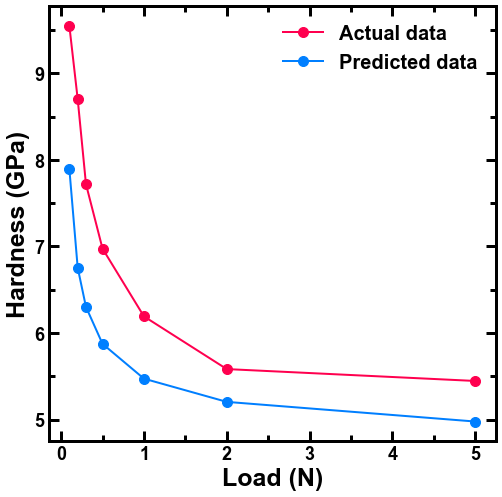

In [27]:
from pylab import rcParams

fig, ax = plt.subplots(figsize = (8,8))
plt.setp(ax.spines.values(), linewidth=3)
plt.plot(renorm_load(load2),renorm_act_hard(hardness2),'-o',color ='#FF004F')

plt.plot(renorm_load(load2),renorm_pred_hard(new_x2,load2).detach().numpy(),'-o',color = '#007FFF')
plt.tick_params(axis="x", which= "both",width = 3)
plt.tick_params(axis="y", which= "both" , width = 3)

plt.xlabel('Load (N)', fontsize = 25)
plt.ylabel('Hardness (GPa)',fontsize = 25)
plt.legend(["Actual data", "Predicted data", "H_infinity"], loc='upper right', fontsize = 20)



## MLHL model

In [28]:
import sys
agrs = sys.argv
from functools import partial

import pandas as pd
import numpy as np
import MLPipeline as MLP
import os
import torch
from sklearn.metrics import r2_score
from new_plot import *
set_things()

In [29]:
ds = pd.read_csv("NBS_136ele.csv")

In [30]:
ds.shape

(7, 6)

In [31]:
X_train = pd.read_csv('04_Pipeline_Combined_Node_train_test_split_train_split_X.csv')

In [32]:
data1 = pd.DataFrame(columns=X_train.columns.tolist()) ### Creating new dataframe as per the training dataset column

In [33]:
data2 = data1.append(ds, ignore_index=True).fillna(0)

In [34]:
X_trn_n = data2[data2.columns[:-1]]


In [35]:
y_trn_n = data2[['HARDNESS']]

## Loading MLHL Model

In [36]:
import json
file2 = "00_Pipeline_Combined_Node_Data Normalization_means_and_stds.json"
ms_file = json.load(open(file2, "rb"))
import pickle
file_name = "01_Pipeline_Combined_Node_Optuna NN_Trial_148_10_model.pkl"
nn_model_loaded = pickle.load(open(file_name, "rb"))

In [37]:
P = MLP.Pipe(name="nor", output="norm")
P.add(MLP.data_cleaning.normalize_data(mean=ms_file["means"], std=ms_file["stds"]))  ##(x-mean)/(std)

X_train_N, y_train_N = P((X_trn_n, y_trn_n))


Pipeline nor is running

Node 0 running.
Node name:  Data Normalization


In [38]:
X_trn_n.shape

(7, 52)

In [39]:
mean=ms_file["means"]
std=ms_file["stds"]
y_test_pred1=nn_model_loaded(torch.tensor(X_train_N.values).float()).detach().numpy()
Y_pred = mean[-1] + y_test_pred1*std[-1]

In [40]:
dr_x = data2.iloc[:,:-1]
dr_x.to_csv('dr_xx.csv', index = False)

In [41]:
dr_y = data2.iloc[:,-1]
dr_y.to_csv('dr_yy.csv', index = False)

In [42]:
dr_xx = pd.read_csv('dr_xx.csv')
dr_yy = pd.read_csv('dr_yy.csv')

In [43]:
dr_x .shape

(7, 52)

In [44]:
P = MLP.Pipe(name="Combined", output="2b_nn_results_test")
P.add(MLP.data_cleaning.normalize_data(mean=ms_file["means"], std=ms_file["stds"]))  ##(x-mean)/(std)

dr_x_N, dr_y_N = P((dr_xx, dr_yy))



Pipeline Combined is running

Node 0 running.
Node name:  Data Normalization


In [46]:
dr_yy_pred=nn_model_loaded(torch.tensor(dr_x_N.values).float()).detach().numpy()

In [47]:
dr_yy_pred_rn = mean[-1]+dr_yy_pred*std[-1]


In [48]:
dr_x_L = dr_x.iloc[:,-1]

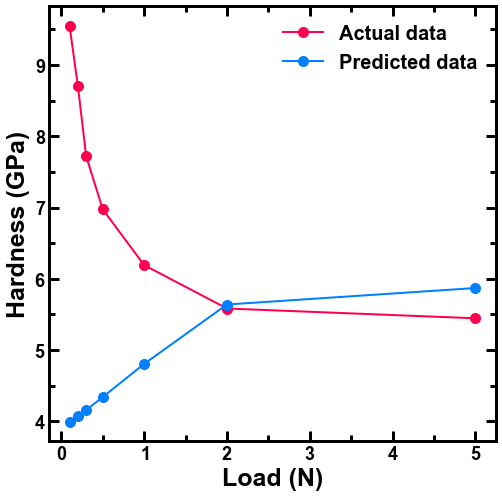

In [50]:
from pylab import rcParams
fig, ax = plt.subplots(figsize = (8,8))
plt.setp(ax.spines.values(), linewidth=3)
plt.plot(dr_x_L,dr_y,'-o',color ='#FF004F')
#plt.scatter(dr_x_L,dr_yy_pred_rn ,s =60,'-o',color ='#FF004F')
plt.plot(dr_x_L,dr_yy_pred_rn,'-o',color ='#007FFF')

plt.xlabel('Load (N)' , fontsize =25)
plt.ylabel('Hardness (GPa)', fontsize =25)
plt.legend(["Actual data",  "Predicted data" ], loc='upper right' , fontsize =20)
plt.tick_params(axis="x", which= "both",width = 3)
plt.tick_params(axis="y", which= "both" , width = 3)
# plt.tick_params(which='minor',length=6,width=2,labelsize=18, direction ='in')
# plt.tick_params(which='major',length=10,width=2,labelsize=18,direction ='in')
#plt.ylim([5.5,7])
# plt.savefig('NBS_136.tif',format='tif', dpi=1200)

## Comparison plot

Text(0.5, 1.0, 'NBS')

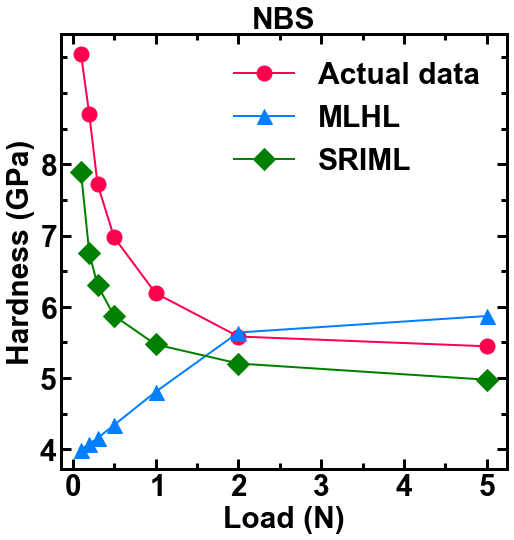

In [51]:
from pylab import rcParams
fig, ax = plt.subplots(figsize = (8,8))
plt.setp(ax.spines.values(), linewidth=3)
# rcParams['figure.figsize'] = 6, 6
plt.plot(dr_x_L,dr_y,'-o', ms =15 ,color ='#FF004F')
#plt.scatter(dr_x_L,dr_yy_pred_rn ,s =60,'-o',color ='#FF004F')
plt.plot(dr_x_L,dr_yy_pred_rn,'-^',ms =15,color ='#007FFF')
# plt.plot(renorm_load(load2),renorm_act_hard(hardness2),'-o',color ='#FF004F')

plt.plot(renorm_load(load2),renorm_pred_hard(new_x2,load2).detach().numpy(),'-D',ms =15,color = 'green')
plt.xlabel('Load (N)' , fontsize =30)
plt.ylabel('Hardness (GPa)', fontsize =30)
plt.legend(["Actual data", "MLHL" ,"SRIML"], loc='upper right' , fontsize =30)
plt.tick_params(axis="x",labelsize=30, which= "both",width = 3)
plt.tick_params(axis="y",labelsize=30, which= "both" , width = 3)
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(4, 9, 1))
plt.title('NBS',fontsize =30)
# plt.savefig('NBS_136.tif',format='tif', dpi=1200)